In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


# <h1 style = "font-size:60px"> 🧠 **STROKE PREDICTION** </h1>

# 1. Introduction
## 1.1 Context

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

## 1.2 Problem Statement
Visualice las relaciones entre varios hábitos saludables y no saludables para los accidentes cerebrovasculares y prediga la probabilidad de accidente cerebrovascular con el mejor modelo y parámetros hiperajustados.

## 1.3  Available Features

**Target**
1. **stroke**: 1 if the patient had a stroke or 0 if not.


**Clinical features for predicting stroke events:**

1. **id**: unique identifier.
2. **gender**: "Male", "Female" or "Other".
3. **age**: age of the patient.
4. **hypertension**: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension.
5. **heart_disease**: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease.
6. **ever_married**: "No" or "Yes".
7. **work_type**: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed".
8. **Residence_type**: "Rural" or "Urban".
9. **avg_glucose_level**: average glucose level in blood.
10. **bmi**: body mass index.
11. **smoking_status**: "formerly smoked", "never smoked", "smokes" or "Unknown".

## 1.4 Objective

El objetivo de nuestro problema de regresión es utilizar las 13 primeras características para predecir el valor de MEDV (que representa el precio de la vivienda).

## 1.5 Questions and Assumptions

1. Does age has impact on strokes? and How is this parameter distributed?
2. Does body mass index and glucose levels in a person, propel a heart stroke?
3. Assumption: Smoking can induce Stroke, is it true?
4. Assumption: Heart with a Heart Disease is prone to Stroke, is it true?
5. Assumption: Workload results in high blood pressure and that could lead to Stroke, is it true?
6. Assumption: Males are most susceptible to strokes due to high work related stress, is it true?
7. Relationship between continous and categorical data
8. Feature importance and Feature Selection for accurate predictions



___
# 2. Pre-requisites and Utilities
## 2.1 Libraries

In [42]:
# Data Manipulation.
import pandas as pd
import numpy as np

# Data Visualization.
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# Dimencionality Reduction.
from sklearn.decomposition import PCA

# Warnings.
import warnings
warnings.filterwarnings("ignore")

## 2.2 Auxiliary Functions

In [24]:
# Create a DF with the revision of the data (value count, type, null, infinity).
def df_revision(df):
    
    col_values_count = {}
    col_dtype = {}
    col_isObj = {}
    col_na = {}
    col_inf = {}

    for i in df.columns:
        col_values_count[i] = df[i].value_counts().shape[0]

    for i in df.columns:
        col_dtype[i] = df[i].dtype

    for i in df.columns:
        if df[i].dtype in ['object', 'string']:
            col_isObj[i] = '✅'
        else:
            col_isObj[i] = '-'

    for i in df.columns:
        col_na[i] = df[i].isna().any()
        if col_na[i] == True:
            col_na[i] = '✅'
        else:
            col_na[i] = '-'


    for i in df.columns:
        col_inf[i] = df[i].isin([np.inf, - np.inf]).any()
        if col_inf[i] == True:
            col_inf[i] = '✅'
        else:
            col_inf[i] = '-'
    
    df_revision = pd.DataFrame([col_values_count, col_dtype, col_isObj, col_na, col_inf], index=['Values_Count', 'DType','Is_Obj', 'NA', 'inf']).transpose()

    return df_revision

___
# 3. Data Wrangling

## 3.1 Data Loading

In [25]:
df = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## 3.2 Descriptive Analysis

### 3.2.1 Statistics of Categorical and Numerical Data

In [26]:
round(df.describe(include='all').fillna('-'), 2)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110.0,5110,5110.0,5110.0,5110.0,5110,5110,5110,5110.0,4909.0,5110,5110.0
unique,-,3,-,-,-,2,5,2,-,-,4,-
top,-,Female,-,-,-,Yes,Private,Urban,-,-,never smoked,-
freq,-,2994,-,-,-,3353,2925,2596,-,-,1892,-
mean,36517.829354,-,43.226614,0.097456,0.054012,-,-,-,106.147677,28.893237,-,0.048728
std,21161.721625,-,22.612647,0.296607,0.226063,-,-,-,45.28356,7.854067,-,0.21532
min,67.0,-,0.08,0.0,0.0,-,-,-,55.12,10.3,-,0.0
25%,17741.25,-,25.0,0.0,0.0,-,-,-,77.245,23.5,-,0.0
50%,36932.0,-,45.0,0.0,0.0,-,-,-,91.885,28.1,-,0.0
75%,54682.0,-,61.0,0.0,0.0,-,-,-,114.09,33.1,-,0.0


### 3.2.2 Data Revision

In [27]:
# The 'df revision' auxiliary function is used.
df_revision(df)

,Values_Count,DType,Is_Obj,NA,inf
id,5110,int64,-,-,-
gender,3,object,✅,-,-
age,104,float64,-,-,-
hypertension,2,int64,-,-,-
heart_disease,2,int64,-,-,-
ever_married,2,object,✅,-,-
work_type,5,object,✅,-,-
Residence_type,2,object,✅,-,-
avg_glucose_level,3979,float64,-,-,-
bmi,418,float64,-,✅,-


### 3.2.3 Count Values of Target 

In [28]:
stroke_count = pd.DataFrame(df['stroke'].value_counts()).rename({'stroke':'Count'}, axis=1)
stroke_count_percent = ((pd.DataFrame(df['stroke'].value_counts())/len(df))*100).round(2).rename({'stroke':'Percent'}, axis=1)

pd.concat([stroke_count, stroke_count_percent], axis=1)

,Count,Percent
0,4861,95.13
1,249,4.87


### 3.2.4 Initial Insights About Dataset

1. Data from bmi feature is missing.
2. Both Categorical and numerical features are present.
    * Categorical Features: gender, ever_married, work_type, Residence_type, smoking_status
    * Binary Numerical Features: hypertension,heart_disease, stroke
    * Continous Numerical Features: age, avg_glucose_level, bmi
3. Most of the data is categorical which need a special attention to visulaize those
4. Feature extraction can be done by binning the continous features ( age, sugar level, and bmi) and let's keep every things as it is.

## 3.3 Pre-processing

### 3.3.1 Missing Values

In [29]:
# The NA in the 'bmi' characteristic are reviewed.
df['bmi'].isna().sum()

201

In [30]:
# We fill NA of the characteristic 'bmi' with the median of its values.
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

# We check the NA
df['bmi'].isna().sum()

0

### 3.3.2 Remove Unnecessary Categories

In [31]:
# Delete of feature "id"
df = df.drop('id', axis=1)

### 3.3.2 Encode DataFrame

In [32]:
col_encode = ['gender', 'ever_married', 'Residence_type', 'work_type', 'smoking_status']

df_encode = pd.get_dummies(df, columns=col_encode, prefix_sep='_', drop_first=True)
df_encode

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,Residence_type_Urban,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,1,0,1,1,0,1,0,0,1,0,0
1,61.0,0,0,202.21,28.1,1,0,0,1,0,0,0,1,0,0,1,0
2,80.0,0,1,105.92,32.5,1,1,0,1,0,0,1,0,0,0,1,0
3,49.0,0,0,171.23,34.4,1,0,0,1,1,0,1,0,0,0,0,1
4,79.0,1,0,174.12,24.0,1,0,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.75,28.1,0,0,0,1,1,0,1,0,0,0,1,0
5106,81.0,0,0,125.20,40.0,0,0,0,1,1,0,0,1,0,0,1,0
5107,35.0,0,0,82.99,30.6,0,0,0,1,0,0,0,1,0,0,1,0
5108,51.0,0,0,166.29,25.6,0,1,0,1,0,0,1,0,0,1,0,0


### 3.3.3 Separate Features

In [33]:
# Categorical Features (Delete Target Because it's a Features of Type "int64")
features_cat = df.select_dtypes(include=['object', 'int64']).columns
features_cat = features_cat.drop(['stroke'])

# Numerical Features
features_num = df.select_dtypes(include='float64').columns

# Target
target = df['stroke']

# Encode Features of DataFrame without Target
features_encode = df_encode.drop(['stroke'], axis=1)

### 3.3.4 Dimensionality Reduction (PCA)

In [34]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(features_encode)

df_pca = pd.DataFrame(df_pca, columns=['feature_1','feature_2'])
df_reduce = pd.concat([df_pca, df['stroke']], axis=1)

print("After PCA the variance for each feature was preserved in a: ", ((pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100).round(2))
print("\n", df_reduce)

After PCA the variance for each feature was preserved in a:  97.96

        feature_1  feature_2  stroke
0     124.928142  -5.024924       1
1      97.576797  -2.340395       1
2       5.547777 -36.531708       1
3      65.341816   3.897361       1
4      72.470168 -23.948346       1
...          ...        ...     ...
5105  -16.490282 -39.516094       0
5106   24.985103 -35.326996       0
5107  -24.076811   4.248923       0
5108   60.485147   2.132382       0
5109  -20.576312  -3.731349       0

[5110 rows x 3 columns]


___
# 4. Visual Analysis
## 4.2 Graphical Representation of Data Distribution

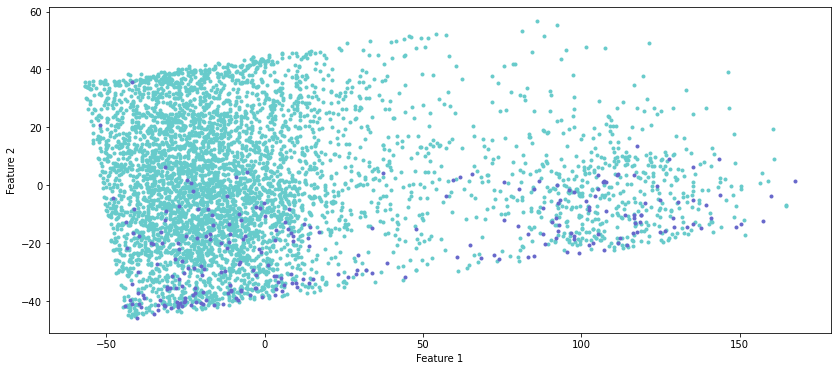

In [126]:
plt.figure(figsize=(14, 6))
plt.scatter(df_reduce["feature_1"][df_reduce['stroke'] == 0], df_reduce["feature_2"][df_reduce['stroke'] == 0], c="#67CBCB", marker=".")
plt.scatter(df_reduce["feature_1"][df_reduce['stroke'] == 1], df_reduce["feature_2"][df_reduce['stroke'] == 1],c="#6767cb", marker=".")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## 4.2 Univariate Analysis
### 4.2.1 Visualization of Categorical Features

In [158]:
features_cat

Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smoking_status'],
      dtype='object')

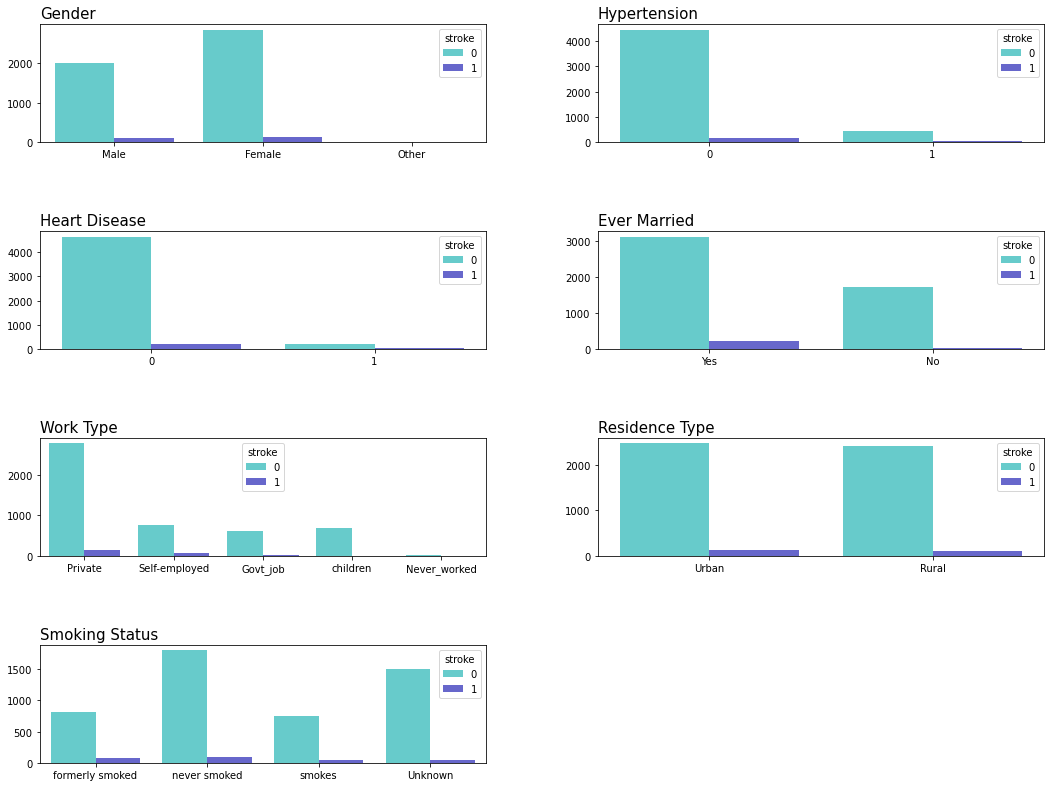

In [161]:
palette = sns.hls_palette(h=.5)

fig = plt.figure(figsize=(18,25))
gs =  gridspec.GridSpec(7,2)
gs.update(wspace=0.25, hspace=0.75)

description = ['Gender',
               'Hypertension',
               'Heart Disease',
               'Ever Married',
               'Work Type',
               'Residence Type',
               'Smoking Status']

for i, j in enumerate(features_cat.values):
    ax = plt.subplot(gs[i])
    sns.countplot(df[j], hue=df['stroke'], palette=palette)
    ax.set_title(description[i], loc='left', fontdict={'fontsize':15})
    ax.set_xlabel('')
    ax.set_ylabel('')
    
plt.show()

### 4.2.2 Visualization of Count Features

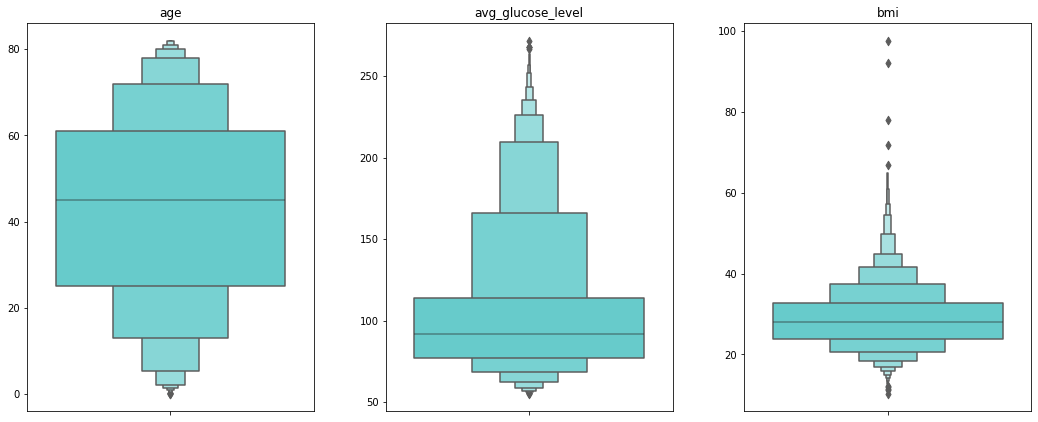

In [108]:
fig = plt.figure(figsize=(18,25))
gs = gridspec.GridSpec(3,3)
gs.update(wspace=0.25, hspace=0.25)

for i, j in enumerate(features_num.values):
    ax = plt.subplot(gs[i])
    sns.boxenplot(y=df[j], palette=palette)
    ax.set_title(str(j))
    ax.set_xlabel('')
    ax.set_ylabel('')

### 4.2.3 Visualization of Target

Text(0, 0.5, '')

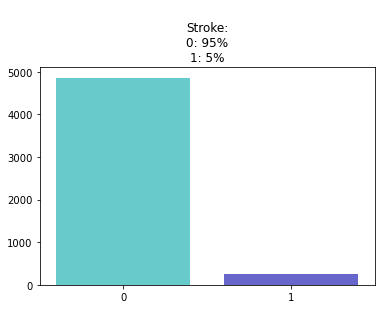

In [109]:
ax_t = sns.countplot(target, palette=palette)
ax_t.set_title(f"""
Stroke:
0: {round(((df['stroke'].value_counts()[0])/sum(df['stroke'].value_counts()))*100)}%
1: {round(((df['stroke'].value_counts()[1])/sum(df['stroke'].value_counts()))*100)}%""")
ax_t.set_xlabel('')
ax_t.set_ylabel('')

## 4.3 Distribution of Features According to Target

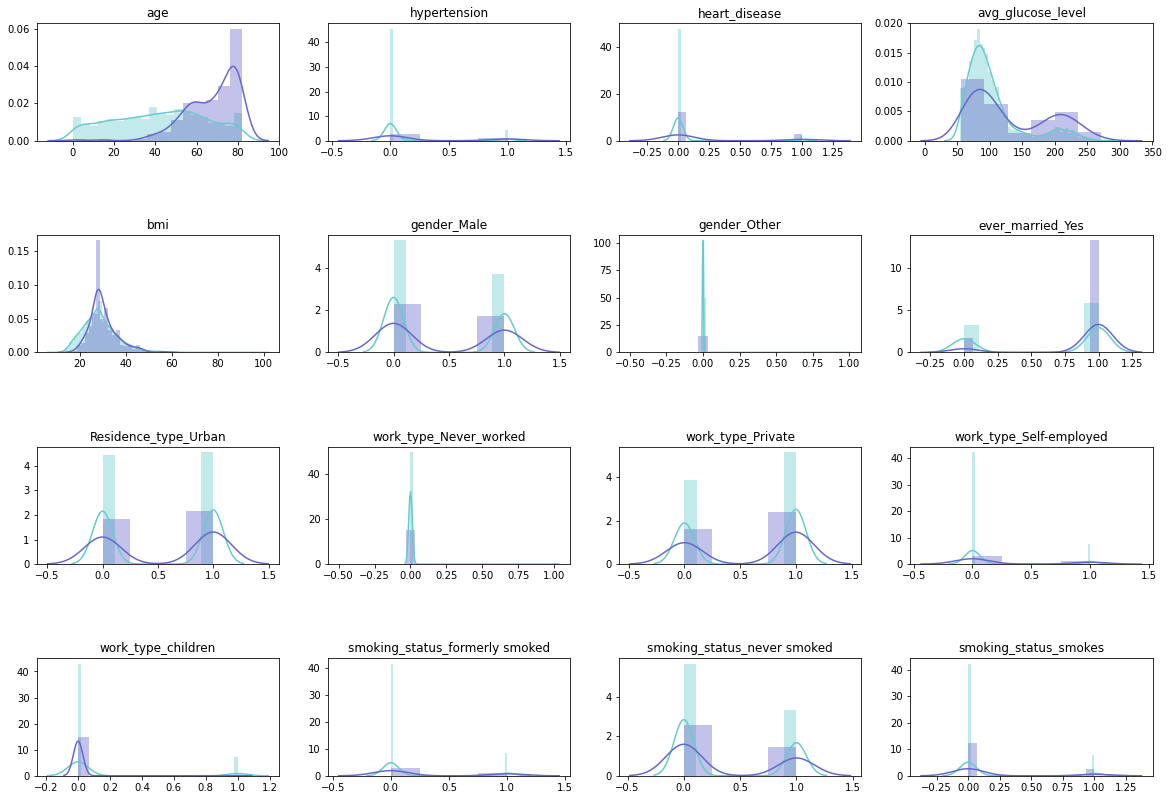

In [114]:
plt.figure(figsize=(20,45))
gs = gridspec.GridSpec(12,4)
gs.update(hspace=0.8)

for i, j in enumerate(features_encode):
    ax = plt.subplot(gs[i])
    sns.distplot(df_encode[j][df_encode['stroke']==0], color='#67CBCB')
    sns.distplot(df_encode[j][df_encode['stroke']==1], color='#6767cb')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(str(j))

plt.show()

## 4.4 Correlation of the Features

### 4.4.1 Visualization of Matrix Correlation

<AxesSubplot:>

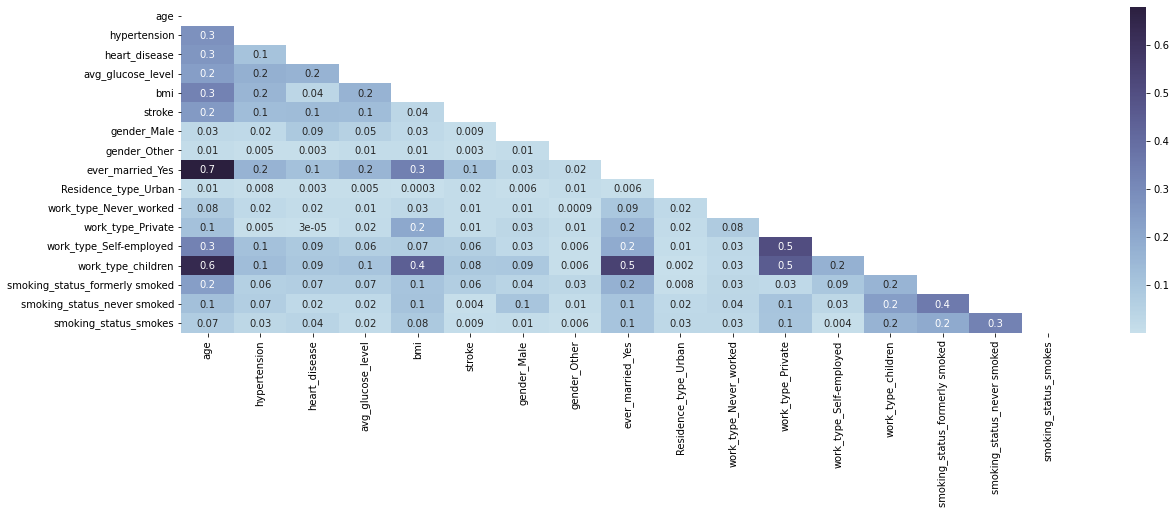

In [124]:
plt.subplots(figsize=(20,6))

df_corr = abs(df_encode.corr())
mask = np.triu(df_corr)
cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

sns.heatmap(df_corr, annot=True, fmt='.1g', cmap=cmap, cbar=True, mask = mask)

### 4.4.2 Higher Correlation with the Target

In [41]:
df_corr = pd.DataFrame(df_corr['stroke'].sort_values(ascending=False))
df_corr

,stroke
stroke,1.000000
age,0.245257
heart_disease,0.134914
avg_glucose_level,0.131945
hypertension,0.127904
ever_married_Yes,0.108340
work_type_children,0.083869
smoking_status_formerly smoked,0.064556
work_type_Self-employed,0.062168
bmi,0.036110
